VAE Generation

Epoch 1, Loss: 0.9237277368976645
Epoch 2, Loss: 0.804581537638625
Epoch 3, Loss: 0.758925831481202
Epoch 4, Loss: 0.7397000838632453
Epoch 5, Loss: 0.7268781698729894
Epoch 6, Loss: 0.732604832681891
Epoch 7, Loss: 0.7208105562484428
Epoch 8, Loss: 0.7230480043855432
Epoch 9, Loss: 0.7149744670685023
Epoch 10, Loss: 0.7134864077176133
Epoch 11, Loss: 0.7107567395249458
Epoch 12, Loss: 0.7097782778413328
Epoch 13, Loss: 0.7067694170017765
Epoch 14, Loss: 0.7063545331563035
Epoch 15, Loss: 0.7069625193125582
Epoch 16, Loss: 0.6987783516923042
Epoch 17, Loss: 0.7060036373465028
Epoch 18, Loss: 0.701891402675681
Epoch 19, Loss: 0.6963473962594385
Epoch 20, Loss: 0.6978347922024661
Epoch 21, Loss: 0.6990552507851222
Epoch 22, Loss: 0.6944152896534906
Epoch 23, Loss: 0.6965008867930059
Epoch 24, Loss: 0.6923277949633664
Epoch 25, Loss: 0.693294154454584
Epoch 26, Loss: 0.6922815515570444
Epoch 27, Loss: 0.6910360243222485
Epoch 28, Loss: 0.692950187480613
Epoch 29, Loss: 0.686585395303491
E

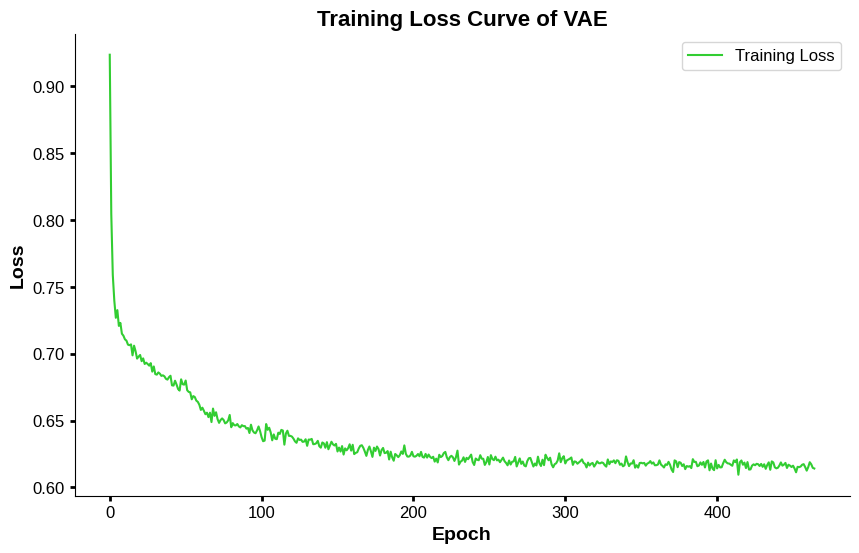

In [ ]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Hydrogel_ML_data.csv')
dataset = df.values

X = dataset[:, 0:7]
Y = dataset[:, 7:9]

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

X_tensor = torch.tensor(X_scaled, dtype = torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype = torch.float32)

data = TensorDataset(Y_tensor, X_tensor)
data_loader = DataLoader(data, batch_size = 32, shuffle = True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, 2)
        self.fc22 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.2)

        self.fc4 = nn.Linear(2, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 7)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout(h2)
        h3 = F.relu(self.fc3(h2))
        h3 = self.dropout(h3)
        return self.fc21(h3), self.fc22(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h4 = F.relu(self.fc4(z))
        h4 = self.dropout(h4)
        h5 = F.relu(self.fc5(h4))
        h5 = self.dropout(h5)
        h6 = F.relu(self.fc6(h5))
        h6 = self.dropout(h6)
        return torch.sigmoid(self.fc7(h6))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.001*KLD

def train(model, data_loader, epochs=100, patience = 50):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

    best_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []

    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (y, x) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(y)
            loss = vae_loss(recon_batch, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(data_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_train_loss}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in loss for {patience} consecutive epochs.")
            break

        scheduler.step()


    plt.rcParams["font.family"] = "Liberation Sans"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color = 'limegreen')
    plt.legend(loc='upper right')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.xlabel('Epoch', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
    plt.title('Training Loss Curve of VAE', fontsize = 16, fontweight = 'bold')
    plt.legend()
    plt.show()

epochs = 500
vae = VAE()
train(vae, data_loader, epochs)

In [ ]:
def generate_outputs(model, input_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        input_data_scaled = Y_scaler.transform(input_data)
        mu, logvar = model.encode(torch.tensor(input_data_scaled, dtype=torch.float32))
        outputs = []
        for _ in range(num_samples):

            z = model.reparameterize(mu, logvar)
            output = model.decode(z)
            output = X_scaler.inverse_transform(output.numpy())
            outputs.append(output)
    return outputs

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/actual_data_round.csv')

storage_modulus = df_1['Storage modulus (Pa)'].tolist()
loss_modulus = df_1['Loss modulus (Pa)'].tolist()

import pandas as pd
import numpy as np


columns = ['Acrylamide Conc. %', 'Bis-acrylamide conc %', 'Photo-initiator conc. %', 'Layer Height. (micron)',
          'Bottom Layer exposure time (s) ', 'Exposure time (s)', 'Frequency (Hz)',
          'Storage modulus (Pa)', 'Loss modulus (Pa)']
df_2 = pd.DataFrame(columns=columns)

for i, j in zip(storage_modulus, loss_modulus):
    input_data = [[i, j]]
    output_parameters = generate_outputs(vae, input_data, num_samples=1)[0]
    rounded_output = [round(float(param), 2) for param in output_parameters[0]]
    combined_data = rounded_output + [i, j]

    df_2 = pd.concat([df, pd.DataFrame([combined_data], columns=columns)], ignore_index=True)

df_2.to_csv('/content/drive/MyDrive/generated_outputs_VAE_new.csv', index=False)

T-test

Comparing column: Acrylamide Conc. %
--------------------------------------------------


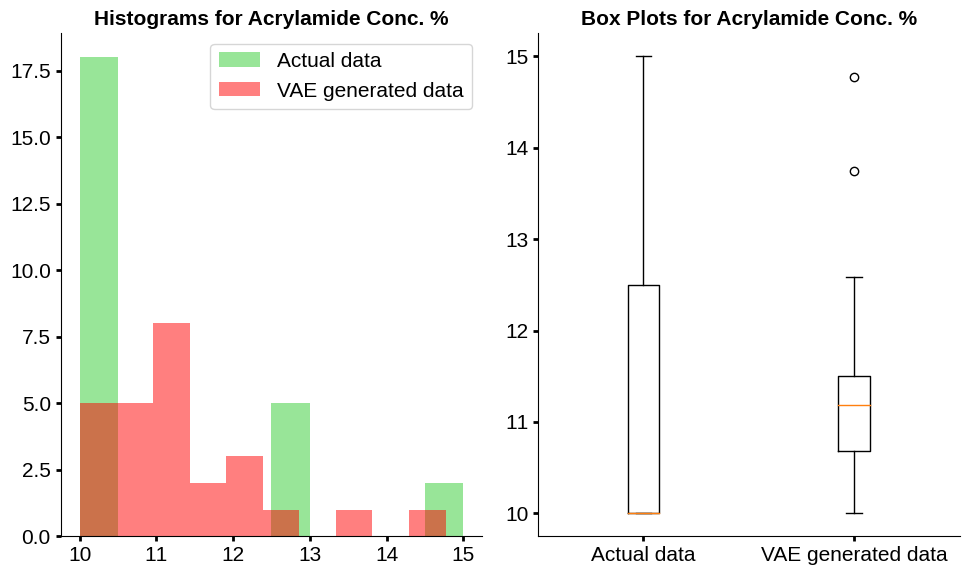

T-test p-value for Acrylamide Conc. %: 0.2521317391298539
The Actual data and the VAE generated data might be statistically similar in column Acrylamide Conc. % (based on t-test).



Comparing column: Bis-acrylamide conc %
--------------------------------------------------


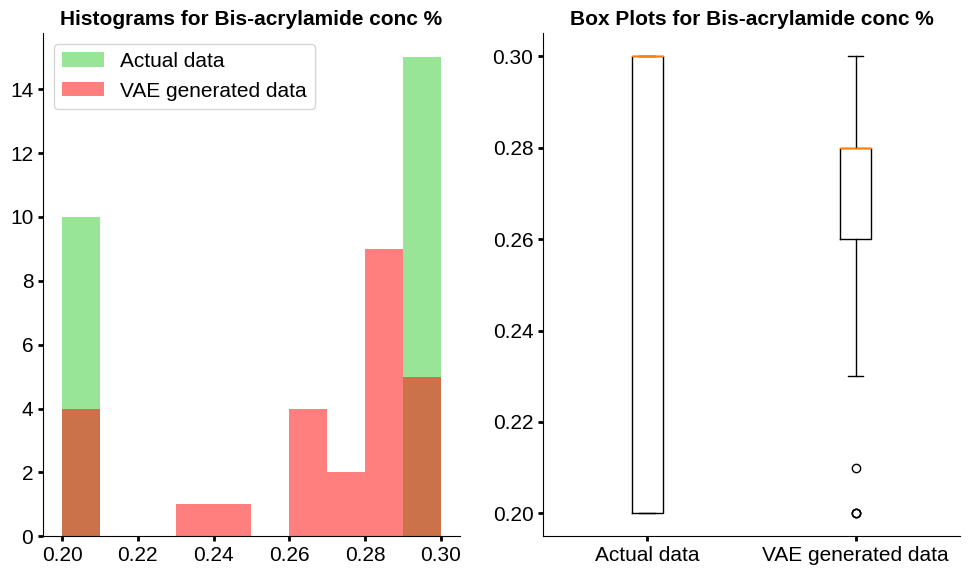

T-test p-value for Bis-acrylamide conc %: 0.7665918008265492
The Actual data and the VAE generated data might be statistically similar in column Bis-acrylamide conc % (based on t-test).



Comparing column: Photo-initiator conc. %
--------------------------------------------------


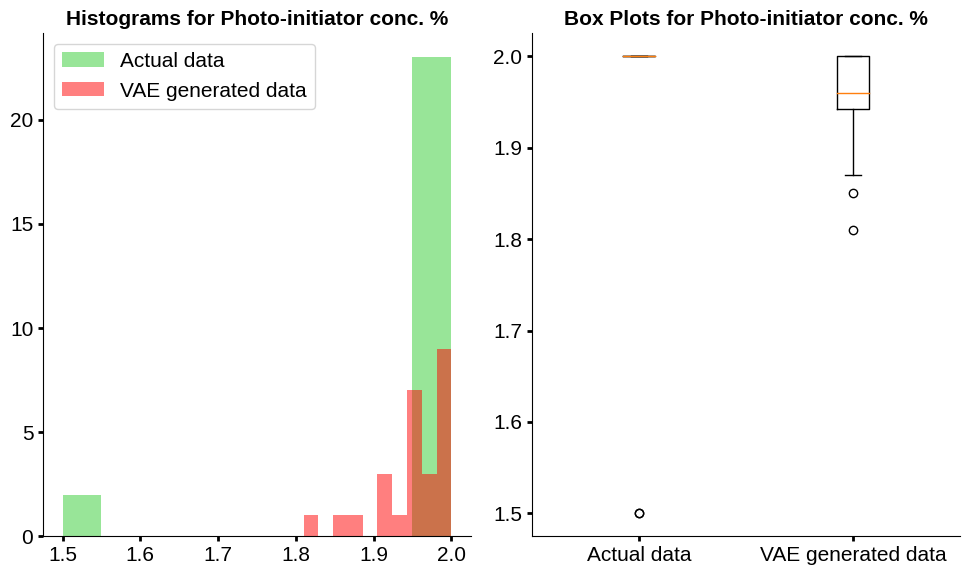

T-test p-value for Photo-initiator conc. %: 0.8531654081119422
The Actual data and the VAE generated data might be statistically similar in column Photo-initiator conc. % (based on t-test).



Comparing column: Layer Height. (micron)
--------------------------------------------------


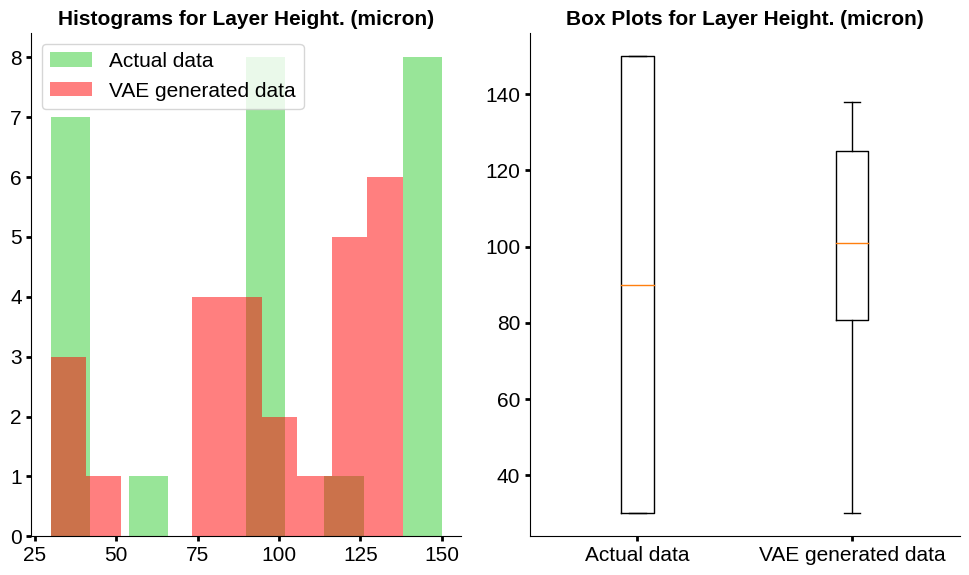

T-test p-value for Layer Height. (micron): 0.6888189942834269
The Actual data and the VAE generated data might be statistically similar in column Layer Height. (micron) (based on t-test).



Comparing column: Bottom Layer exposure time (s) 
--------------------------------------------------


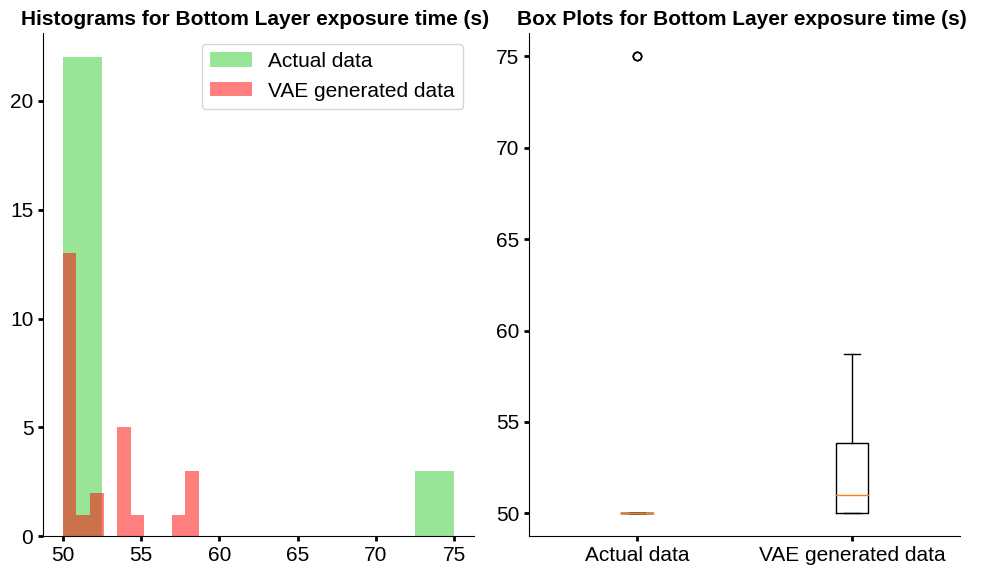

T-test p-value for Bottom Layer exposure time (s) : 0.7253211324859057
The Actual data and the VAE generated data might be statistically similar in column Bottom Layer exposure time (s)  (based on t-test).



Comparing column: Exposure time (s)
--------------------------------------------------


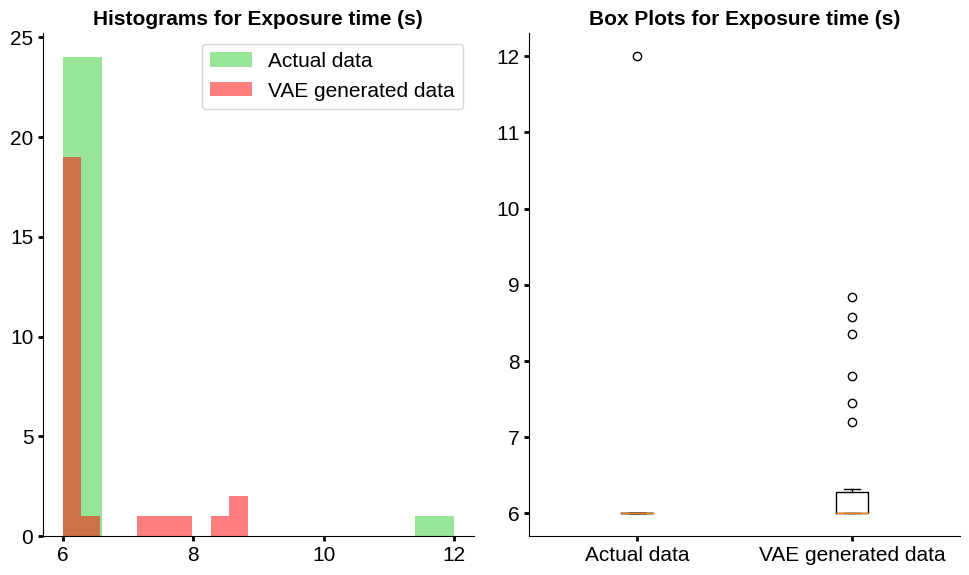

T-test p-value for Exposure time (s): 0.40637793872148875
The Actual data and the VAE generated data might be statistically similar in column Exposure time (s) (based on t-test).



Comparing column: Frequency (Hz)
--------------------------------------------------


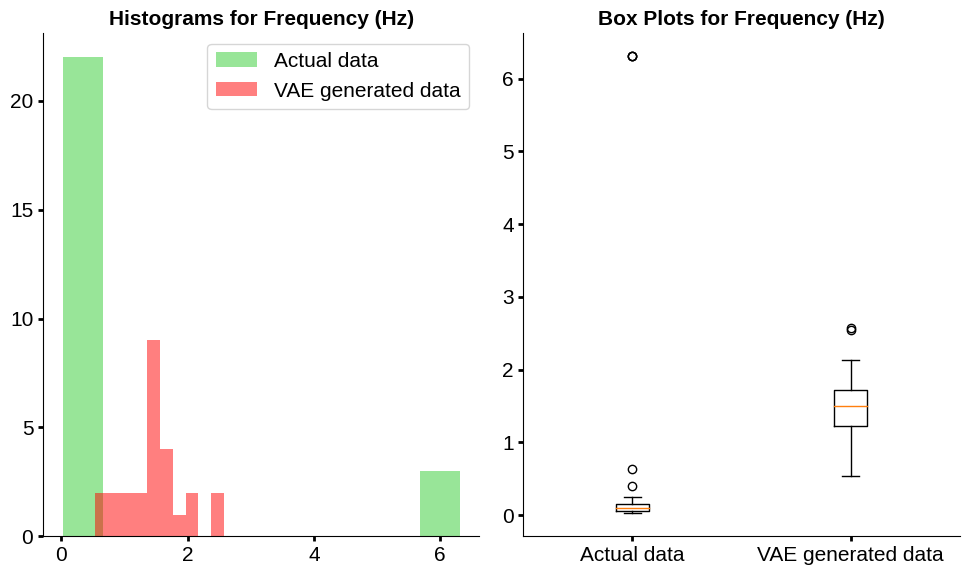

T-test p-value for Frequency (Hz): 0.1408521174642581
The Actual data and the VAE generated data might be statistically similar in column Frequency (Hz) (based on t-test).



Comparing column: Storage modulus (Pa)
--------------------------------------------------


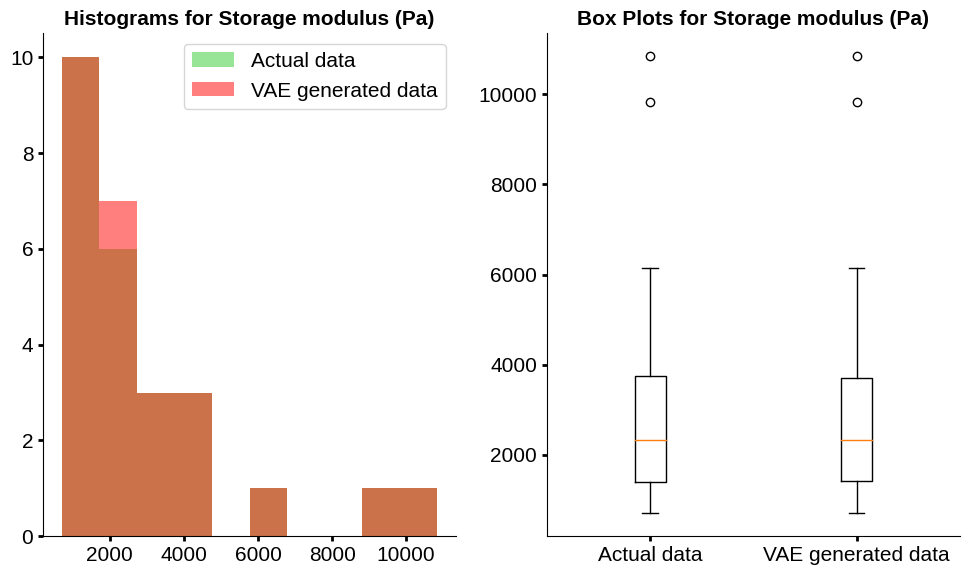

T-test p-value for Storage modulus (Pa): 0.9711669207943867
The Actual data and the VAE generated data might be statistically similar in column Storage modulus (Pa) (based on t-test).



Comparing column: Loss modulus (Pa)
--------------------------------------------------


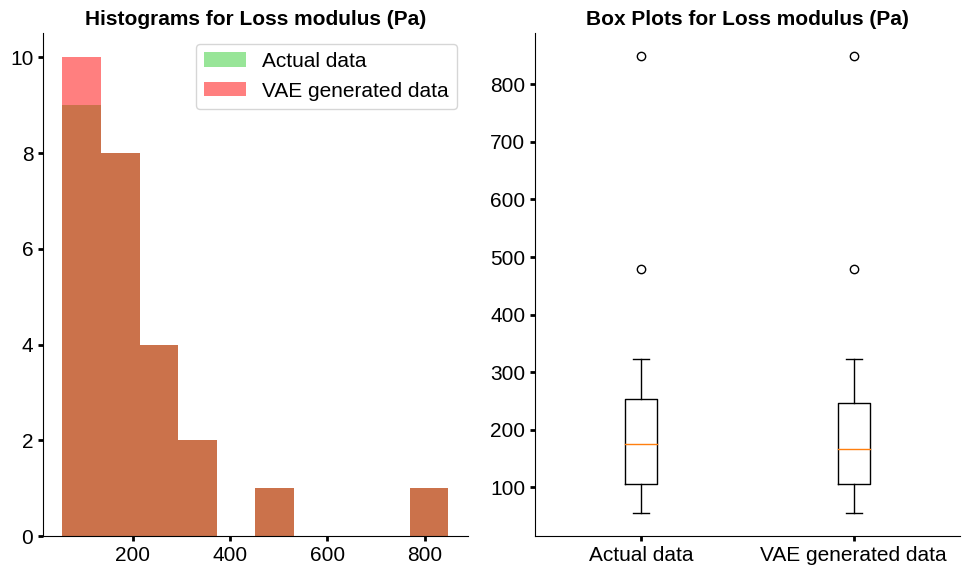

T-test p-value for Loss modulus (Pa): 0.9342740644570766
The Actual data and the VAE generated data might be statistically similar in column Loss modulus (Pa) (based on t-test).





In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

df1 = pd.read_csv('/content/drive/MyDrive/actual_data_round.csv')
df2 = pd.read_csv('/content/drive/MyDrive/generated_outputs_VAE_new.csv')

for col_name in df1.columns:

    col1 = df1[col_name]
    col2 = df2[col_name]

    print(f"Comparing column: {col_name}")
    print('-' * 50)

    '''
    print(col1.describe())
    print(col2.describe())
    '''

    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "Liberation Sans"
    plt.rcParams["font.size"] = 15

    plt.subplot(1, 2, 1)
    plt.hist(col1, alpha=0.5, label='Actual data', color = 'limegreen', linewidth = 2.0)
    plt.hist(col2, alpha=0.5, label='VAE generated data', color = 'r', linewidth = 2.0)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.legend(loc='best')
    plt.title(f'Histograms for {col_name}', fontsize = 15, fontweight = 'bold')

    plt.subplot(1, 2, 2)
    plt.boxplot([col1, col2], labels=['Actual data', 'VAE generated data'])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.title(f'Box Plots for {col_name}', fontsize = 15, fontweight = 'bold')

    plt.tight_layout()
    plt.show()

    t_stat, p_val = ttest_ind(col1, col2)
    print(f"T-test p-value for {col_name}: {p_val}")


    if p_val < 0.05:
        print(f"The Actual data and the VAE generated data are likely statistically different in column {col_name} (based on t-test).")
    else:
        print(f"The Actual data and the VAE generated data might be statistically similar in column {col_name} (based on t-test).")


    print('\n\n')


AE For VAE

Epoch [100/1000], Loss: 0.0653
Epoch [200/1000], Loss: 0.0251
Epoch [300/1000], Loss: 0.0175
Epoch [400/1000], Loss: 0.0139
Epoch [500/1000], Loss: 0.0114
Epoch [600/1000], Loss: 0.0093
Epoch [700/1000], Loss: 0.0101
Epoch [800/1000], Loss: 0.0141
Epoch [900/1000], Loss: 0.0082
Epoch [1000/1000], Loss: 0.0068


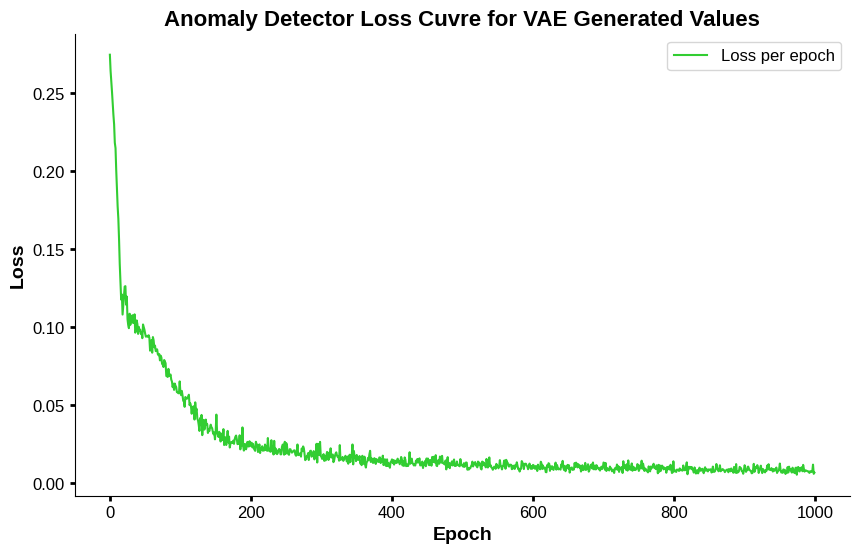

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


real_df = pd.read_csv("/content/drive/MyDrive/actual_data_round.csv")
generated_df = pd.read_csv("/content/drive/MyDrive/generated_outputs_VAE_new.csv")

scaler = MinMaxScaler()
real_data_scaled = scaler.fit_transform(real_df)
generated_data_scaled = scaler.fit_transform(generated_df)

real_data = torch.tensor(real_data_scaled, dtype=torch.float32)
generated_data = torch.tensor(generated_data_scaled, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(9, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 9)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(real_data)
    loss = criterion(outputs, real_data)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.size"] = 12

plt.figure(figsize=(10, 6))

plt.plot(losses, label = 'Loss per epoch', color ='limegreen')
plt.legend(loc='upper right')


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width = 2.0)
ax.yaxis.set_tick_params(width = 2.0)

plt.xlabel('Epoch', fontsize =14 , fontweight='bold')
plt.ylabel('Loss', fontsize =14 , fontweight='bold')
plt.title('Anomaly Detector Loss Cuvre for VAE Generated Values', fontsize =16 , fontweight='bold')

plt.show()

def detect_anomalies(data, model):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data)
        reconstruction_error = ((reconstructions - data) ** 2).sum(dim=1)
        return reconstruction_error

errors = detect_anomalies(generated_data, model)

threshold = errors.mean() + 3 * errors.std()
anomalies = errors > threshold

print(str(anomalies))

CAVE

Epoch 1, Loss: 0.872723495307034
Epoch 2, Loss: 0.5163228617955561
Epoch 3, Loss: 0.35545394620666765
Epoch 4, Loss: 0.1917442188483395
Epoch 5, Loss: 0.1164697207612534
Epoch 6, Loss: 0.08690601873071227
Epoch 7, Loss: 0.07984765210788544
Epoch 8, Loss: 0.07433229985914819
Epoch 9, Loss: 0.06320397336393187
Epoch 10, Loss: 0.05488083649375667
Epoch 11, Loss: 0.05726131674361556
Epoch 12, Loss: 0.054876051741103604
Epoch 13, Loss: 0.053070158838001015
Epoch 14, Loss: 0.04970671445743678
Epoch 15, Loss: 0.048367798889744774
Epoch 16, Loss: 0.04763698353342814
Epoch 17, Loss: 0.04892356101780722
Epoch 18, Loss: 0.04420448594713864
Epoch 19, Loss: 0.04354056134207608
Epoch 20, Loss: 0.04358078695017181
Epoch 21, Loss: 0.03878029326155578
Epoch 22, Loss: 0.043179756004924644
Epoch 23, Loss: 0.03718620967375089
Epoch 24, Loss: 0.04003591113404868
Epoch 25, Loss: 0.03965762155513241
Epoch 26, Loss: 0.03678035746290259
Epoch 27, Loss: 0.03572335433572123
Epoch 28, Loss: 0.038097251385246236
E

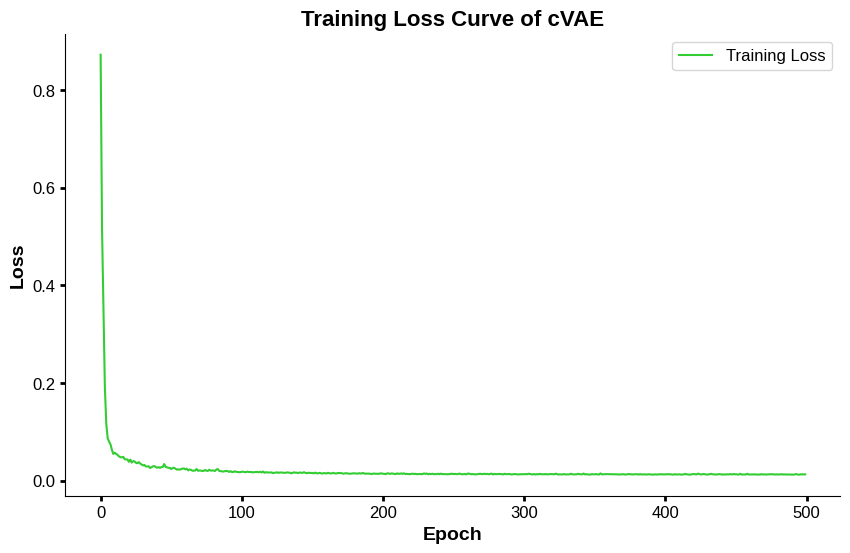

In [ ]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Hydrogel_ML_data.csv')
dataset = df.values

X = dataset[:, 0:7]
Y = dataset[:, 7:9]

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

data = TensorDataset(Y_tensor, X_tensor)
data_loader = DataLoader(data, batch_size=32, shuffle=True)

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, 10)
        self.fc22 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)

        self.fc4 = nn.Linear(12, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 7)

    def encode(self, x, condition):
        combined = torch.cat([x, condition], 1)
        h1 = F.relu(self.fc1(combined))
        h2 = F.relu(self.fc2(self.dropout(h1)))
        h3 = F.relu(self.fc3(self.dropout(h2)))
        return self.fc21(h3), self.fc22(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, condition):
        combined = torch.cat([z, condition], 1)
        h4 = F.relu(self.fc4(combined))
        h5 = F.relu(self.fc5(self.dropout(h4)))
        h6 = F.relu(self.fc6(self.dropout(h5)))
        return torch.sigmoid(self.fc7(self.dropout(h6)))

    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, condition), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.001 * KLD


def train(model, data_loader, epochs=100, patience=50):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

    best_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []


    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (y, x) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x, y)
            loss = vae_loss(recon_batch, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(data_loader.dataset)
        train_losses.append(avg_train_loss)

        print(f'Epoch {epoch+1}, Loss: {avg_train_loss}')

        if avg_train_loss >= patience:
          print(f"Early stopping at epoch {epoch+1}. No improvement in loss for {patience} consequtive epochs")
          break

        scheduler.step()


    plt.rcParams["font.family"] = "Liberation Sans"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color = 'limegreen')
    plt.legend(loc='upper right')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.xlabel('Epoch', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
    plt.title('Training Loss Curve of cVAE', fontsize = 16, fontweight = 'bold')
    plt.legend()
    plt.show()

epochs = 500
cvae = CVAE()
train(cvae, data_loader, epochs)

In [ ]:
def generate_outputs(model, input_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        input_data_scaled = Y_scaler.transform(input_data)
        conditions = torch.tensor(input_data_scaled, dtype=torch.float32)
        outputs = []
        for _ in range(num_samples):
            z = torch.randn((conditions.shape[0], 10))
            output = model.decode(z, conditions)
            output = X_scaler.inverse_transform(output.numpy())
            outputs.append(output)
    return outputs

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/actual_data_round.csv')

storage_modulus = df['Storage modulus (Pa)'].tolist()
loss_modulus = df['Loss modulus (Pa)'].tolist()

columns = ['Acrylamide Conc. %', 'Bis-acrylamide conc %', 'Photo-initiator conc. %', 'Layer Height. (micron)',
          'Bottom Layer exposure time (s) ', 'Exposure time (s)', 'Frequency (Hz)',
          'Storage modulus (Pa)', 'Loss modulus (Pa)']
df_2 = pd.DataFrame(columns=columns)

for i, j in zip(storage_modulus, loss_modulus):
    input_data = [[i, j]]
    output_parameters = generate_outputs(cvae, input_data, num_samples=1)[0]
    rounded_output = [round(float(param), 2) for param in output_parameters[0]]
    combined_data = rounded_output + [i, j]

    df_2 = pd.concat([df_2, pd.DataFrame([combined_data], columns=columns)], ignore_index=True)

df_2.to_csv('/content/drive/MyDrive/generated_outputs_CAVE_new.csv', index=False)


<ipython-input-7-4039ee65a506>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2 = pd.concat([df_2, pd.DataFrame([combined_data], columns=columns)], ignore_index=True)


t-test for CAVE

Comparing column: Acrylamide Conc. %
--------------------------------------------------


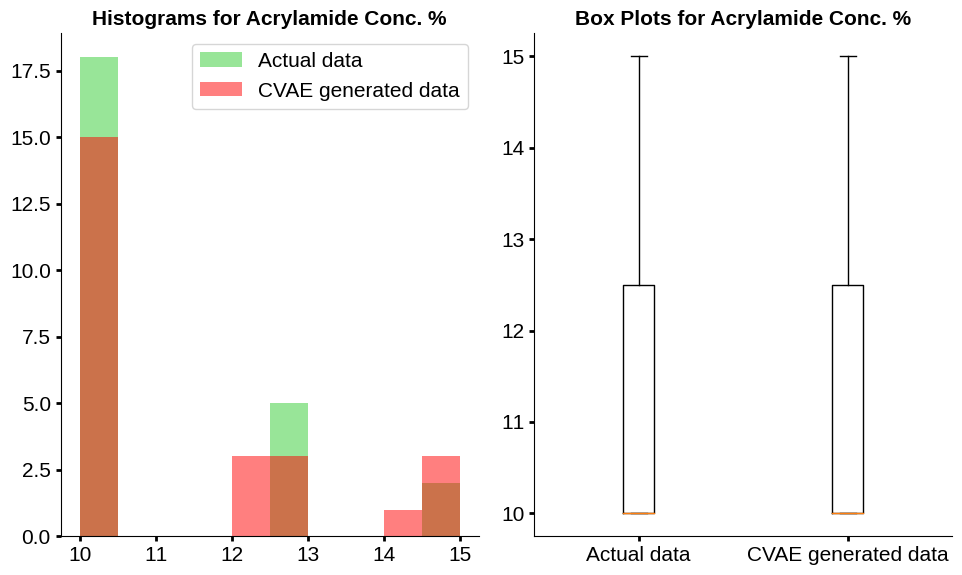

T-test p-value for Acrylamide Conc. %: 0.3287254767714821
The Actual data and the CVAE generated data might be statistically similar in column Acrylamide Conc. % (based on t-test).



Comparing column: Bis-acrylamide conc %
--------------------------------------------------


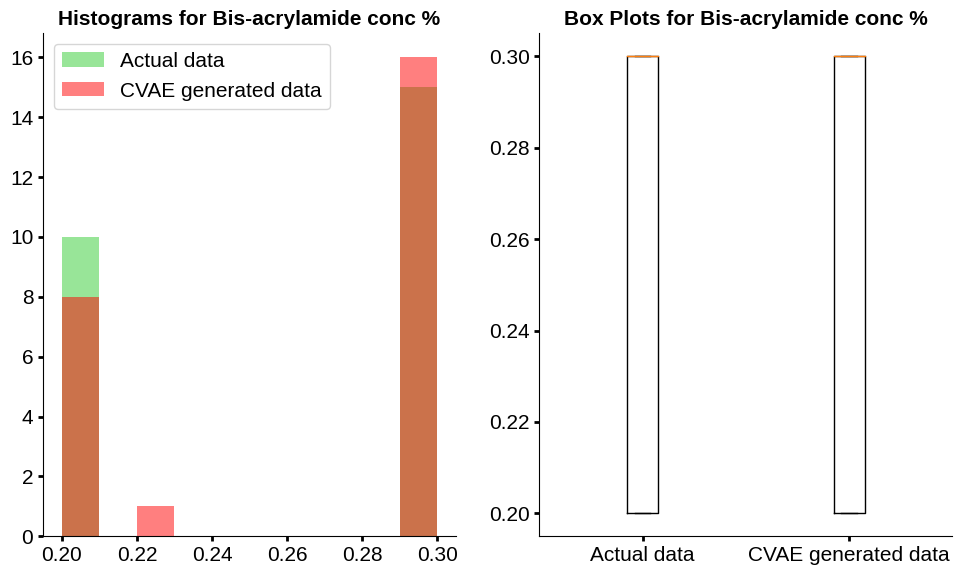

T-test p-value for Bis-acrylamide conc %: 0.7307995678567267
The Actual data and the CVAE generated data might be statistically similar in column Bis-acrylamide conc % (based on t-test).



Comparing column: Photo-initiator conc. %
--------------------------------------------------


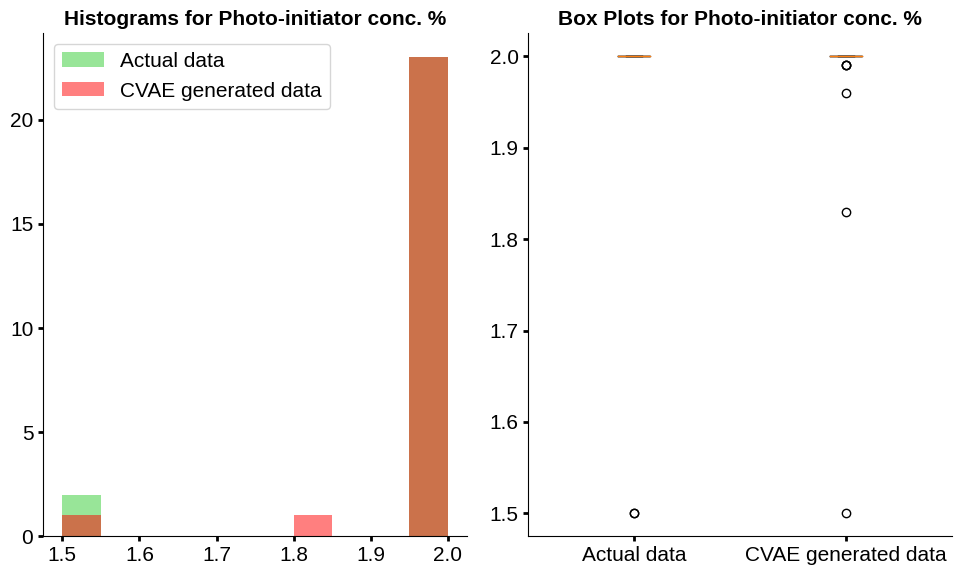

T-test p-value for Photo-initiator conc. %: 0.7651294612720905
The Actual data and the CVAE generated data might be statistically similar in column Photo-initiator conc. % (based on t-test).



Comparing column: Layer Height. (micron)
--------------------------------------------------


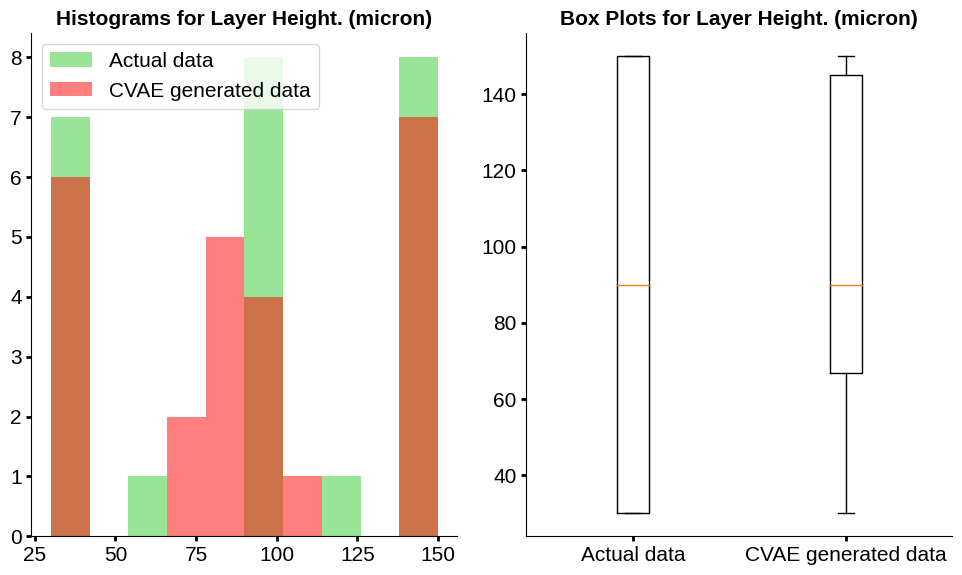

T-test p-value for Layer Height. (micron): 0.9434155453344069
The Actual data and the CVAE generated data might be statistically similar in column Layer Height. (micron) (based on t-test).



Comparing column: Bottom Layer exposure time (s) 
--------------------------------------------------


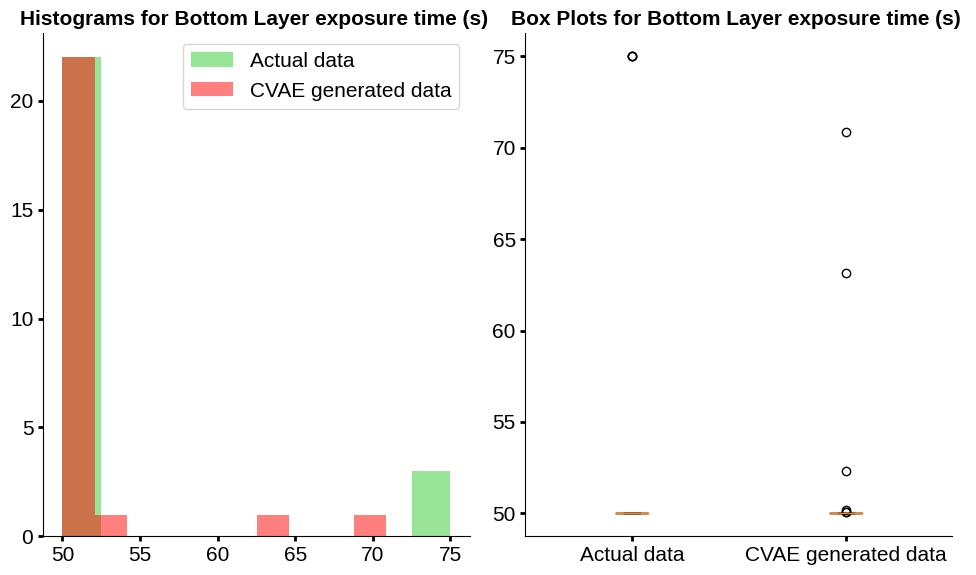

T-test p-value for Bottom Layer exposure time (s) : 0.42821590144454413
The Actual data and the CVAE generated data might be statistically similar in column Bottom Layer exposure time (s)  (based on t-test).



Comparing column: Exposure time (s)
--------------------------------------------------


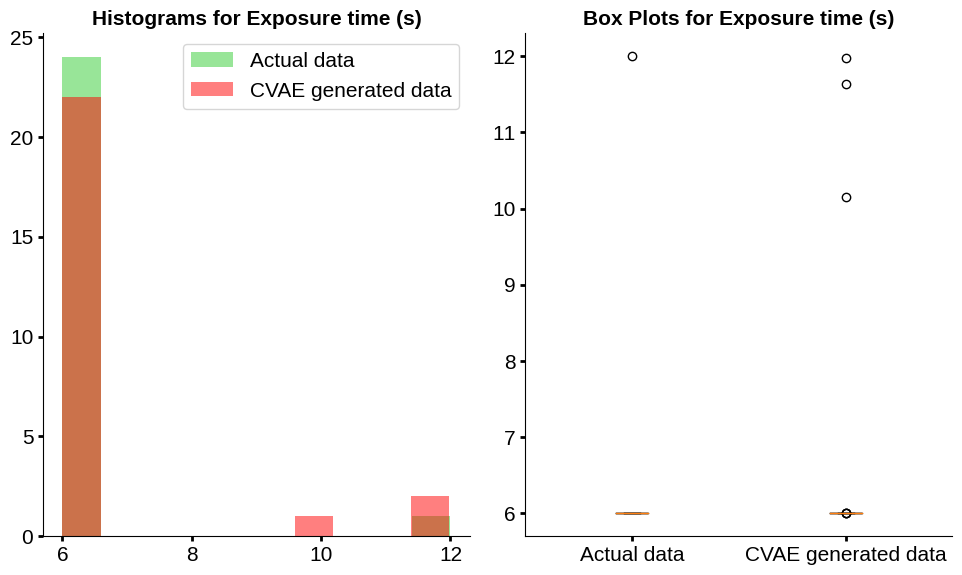

T-test p-value for Exposure time (s): 0.3633940619511683
The Actual data and the CVAE generated data might be statistically similar in column Exposure time (s) (based on t-test).



Comparing column: Frequency (Hz)
--------------------------------------------------


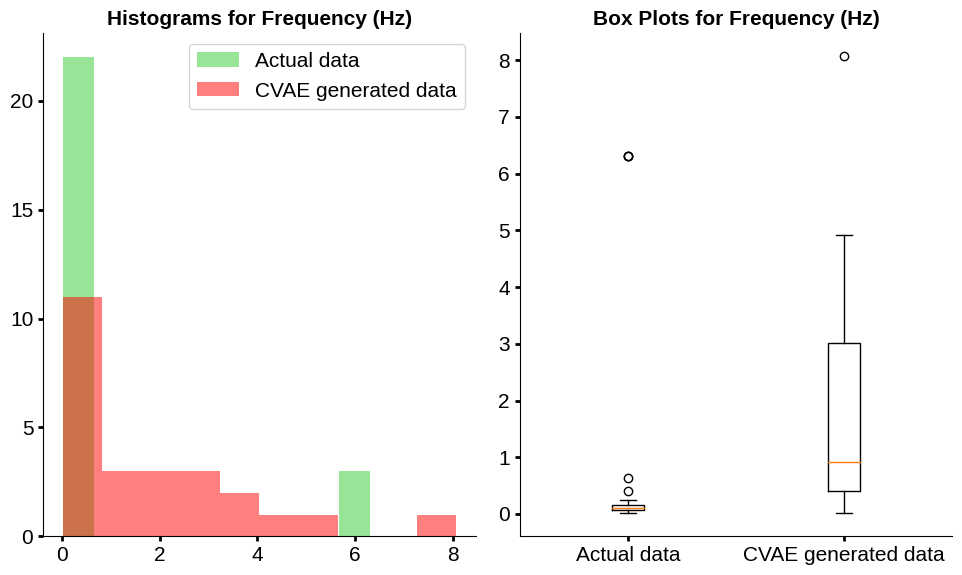

T-test p-value for Frequency (Hz): 0.09813545390896938
The Actual data and the CVAE generated data might be statistically similar in column Frequency (Hz) (based on t-test).



Comparing column: Storage modulus (Pa)
--------------------------------------------------


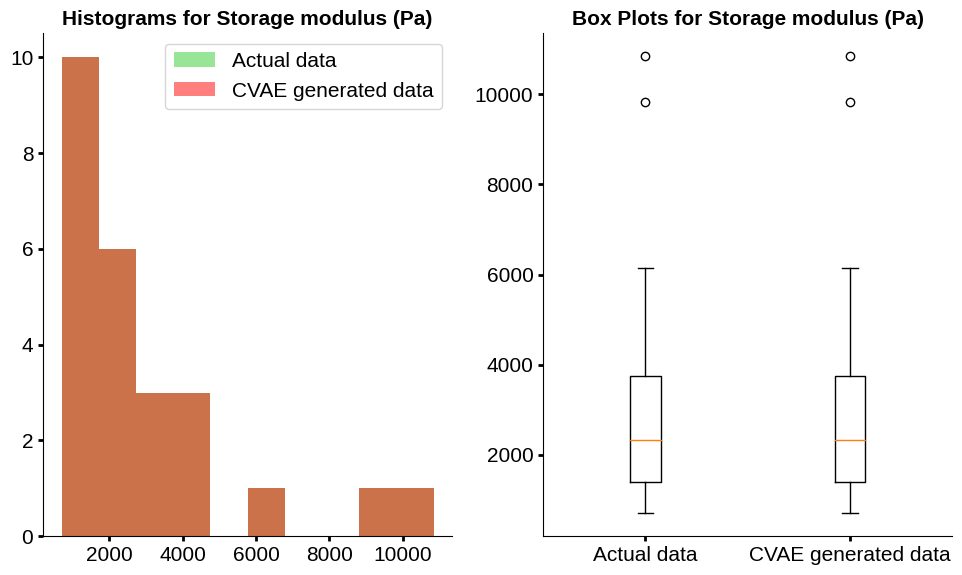

T-test p-value for Storage modulus (Pa): 1.0
The Actual data and the CVAE generated data might be statistically similar in column Storage modulus (Pa) (based on t-test).



Comparing column: Loss modulus (Pa)
--------------------------------------------------


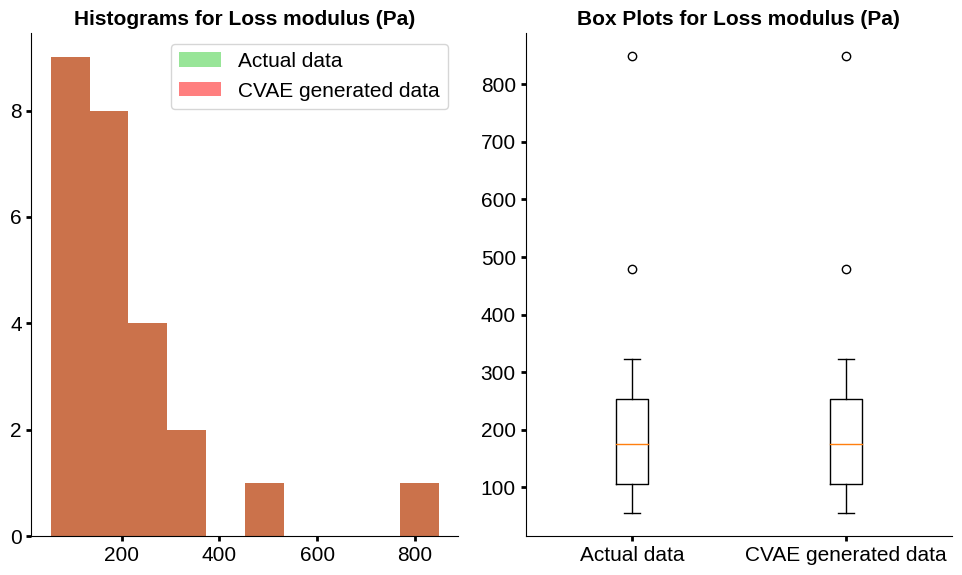

T-test p-value for Loss modulus (Pa): 1.0
The Actual data and the CVAE generated data might be statistically similar in column Loss modulus (Pa) (based on t-test).





In [ ]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

df1 = pd.read_csv('/content/drive/MyDrive/actual_data_round.csv')
df2 = pd.read_csv('/content/drive/MyDrive/generated_outputs_CAVE_new.csv')

for col_name in df1.columns:

    col1 = df1[col_name]
    col2 = df2[col_name]

    print(f"Comparing column: {col_name}")
    print('-' * 50)

    '''
    print(col1.describe())
    print(col2.describe())
    '''

    plt.figure(figsize=(10, 6))
    plt.rcParams["font.family"] = "Liberation Sans"
    plt.rcParams["font.size"] = 15

    plt.subplot(1, 2, 1)
    plt.hist(col1, alpha=0.5, label='Actual data', color = 'limegreen', linewidth = 2.0)
    plt.hist(col2, alpha=0.5, label='CVAE generated data', color = 'r', linewidth = 2.0)
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.legend(loc='best')
    plt.title(f'Histograms for {col_name}', fontsize = 15, fontweight = 'bold')

    plt.subplot(1, 2, 2)
    plt.boxplot([col1, col2], labels=['Actual data', 'CVAE generated data'])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.title(f'Box Plots for {col_name}', fontsize = 15, fontweight = 'bold')

    plt.tight_layout()
    plt.show()


    t_stat, p_val = ttest_ind(col1, col2)
    print(f"T-test p-value for {col_name}: {p_val}")

    if p_val < 0.05:
        print(f"The Actual data and the CVAE generated data are likely statistically different in column {col_name} (based on t-test).")
    else:
        print(f"The Actual data and the CVAE generated data might be statistically similar in column {col_name} (based on t-test).")

    print('\n\n')


AE for CAVE

Epoch [100/1000], Loss: 0.0572
Epoch [200/1000], Loss: 0.0256
Epoch [300/1000], Loss: 0.0224
Epoch [400/1000], Loss: 0.0146
Epoch [500/1000], Loss: 0.0161
Epoch [600/1000], Loss: 0.0105
Epoch [700/1000], Loss: 0.0097
Epoch [800/1000], Loss: 0.0117
Epoch [900/1000], Loss: 0.0069
Epoch [1000/1000], Loss: 0.0071


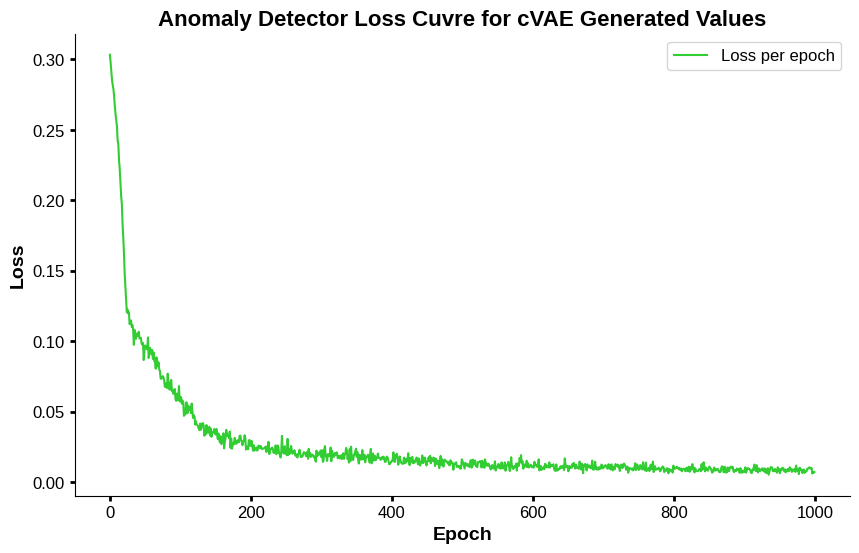

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


real_df = pd.read_csv("/content/drive/MyDrive/actual_data_round.csv")
generated_df = pd.read_csv("/content/drive/MyDrive/generated_outputs_CAVE_new.csv")

scaler = MinMaxScaler()
real_data_scaled = scaler.fit_transform(real_df)
generated_data_scaled = scaler.fit_transform(generated_df)

real_data = torch.tensor(real_data_scaled, dtype=torch.float32)
generated_data = torch.tensor(generated_data_scaled, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(9, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 9)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(real_data)
    loss = criterion(outputs, real_data)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.size"] = 12

plt.figure(figsize=(10, 6))

plt.plot(losses, label = 'Loss per epoch', color ='limegreen')
plt.legend(loc='upper right')


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(width = 2.0)
ax.yaxis.set_tick_params(width = 2.0)

plt.xlabel('Epoch', fontsize =14 , fontweight='bold')
plt.ylabel('Loss', fontsize =14 , fontweight='bold')
plt.title('Anomaly Detector Loss Cuvre for cVAE Generated Values', fontsize =16 , fontweight='bold')

plt.show()

def detect_anomalies(data, model):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data)
        reconstruction_error = ((reconstructions - data) ** 2).sum(dim=1)
        return reconstruction_error

errors = detect_anomalies(generated_data, model)

threshold = errors.mean() + 3 * errors.std()
anomalies = errors > threshold

print(str(anomalies))